# L2: Text classification

Text classification is the task of sorting text documents into predefined classes. The concrete problem you will be working on in this lab is the classification of texts with respect to their political affiliation. The specific texts you are going to classify are speeches held in the [Riksdag](https://www.riksdagen.se/en/), the Swedish national legislature.

**Before starting with this lab, here is a quick reminder about our [Rules for hand-in assignments](https://www.ida.liu.se/~TDDE16/exam.en.shtml#handins) and the [Policy on cheating and plagiarism](https://www.ida.liu.se/~TDDE16/exam.en.shtml#cheating).**

## Data set

The raw data for this lab comes from [The Riksdag‚Äôs Open Data](https://data.riksdagen.se/in-english/). We have tokenized the speeches and put them into two compressed [JSON](https://en.wikipedia.org/wiki/JSON) files:

* `speeches-201718.json.bz2` (speeches from the 2017/2018 parliamentary session)
* `speeches-201819.json.bz2` (ditto, from the 2018/2019 session)

We start by loading these files into two separate data frames.

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
%cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


In [33]:
import pandas as pd
import bz2

with bz2.open('speeches-201718.json.bz2') as source:
    speeches_201718 = pd.read_json(source)

with bz2.open('speeches-201819.json.bz2') as source:
    speeches_201819 = pd.read_json(source)

When you inspect the two data frames, you can see that there are three labelled columns: `id` (the official speech ID), `words` (the space-separated words of the speech), and `party` (the party of the speaker, represented by its customary abbreviation).

In [34]:
speeches_201718.head()

id                                              words party
0  H5-002-004  eders majest√§ter eders kungliga h√∂gheter herr ...     S
1  H5-003-001  aktuell debatt om situationen f√∂r ensamkommand...     V
2  H5-003-002  herr talman och ledam√∂ter jag vill b√∂rja med a...     S
3  H5-003-003  herr talman √•h√∂rare den h√§r debatten handlar a...     M
4  H5-003-004  herr talman ansvar och r√§ttss√§kerhet √§r tv√• or...    SD

Throughout the lab, we will be using the speeches from 2017/2018 as our training data, and the speeches from 2018/2019 as our test data.

In [35]:
training_data, test_data = speeches_201718, speeches_201819

For later reference, we store the sorted list of party abbreviations.

In [36]:
parties = sorted(training_data['party'].unique())
print(parties)

['C', 'KD', 'L', 'M', 'MP', 'S', 'SD', 'V']


## Problem 1: Visualization

Your first task is to get to know the data better by producing a simple visualization.

If you are not familiar with the Swedish political system and the parties represented in the Riksdag in particular, then we suggest that you have a look at the Wikipedia article about the [2018 Swedish general election](https://en.wikipedia.org/wiki/2018_Swedish_general_election).

For the lab, we ask you to compare the two data frames with respect to the distribution of the speeches over the different parties. Write code to generate two bar plots that visualize this information, one for the 2017/2018 speeches and one for the 2018/2019 speeches. Inspect the two plots, and compare them

* to each other
* to the results of the 2014 and the 2018 general elections

Summarize your observations in a short text in the cell below.

**Tip:** If you need help with creating bar plots, [Bar Plot using Pandas](https://dfrieds.com/data-visualizations/bar-plot-python-pandas) provides a useful tutorial.

**A:** 

- Comparing both plots with eachother we can see a similar pattern in the bar plots. S and M are the parties with the most speeches in the Riksdag. We can also observe that party MP had proportionally less speeches in 2018/19 compared to 2017/18. On the other hand KD, SD and V had proportionally more speeches in 2018/19 compared to 2017/18. In general, it can also be seen that the total number of speeches (per party) is lower in 2018/19 compared to 2017/18.

- Comparing to the 2014 and 2018 general elections we can see why MP had less speeches in 2018/19. MP went from 6.9% to 4.4% and lost 9 Riksdag seats. In general, it looks like the proportion of speeches in the Riksdag depends on the number of seats a party owns. One interesting thing to observe is that the C party seems to have less speeches compared to their proportion of seats in the Riksdag.

In [37]:
import matplotlib.pyplot as plt
import numpy as np

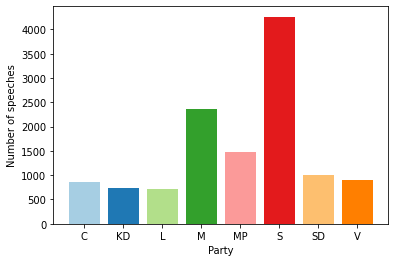

In [38]:
counts_1718 = speeches_201718.groupby(["party"]).size().reset_index(name='counts')

plt.bar(counts_1718["party"], counts_1718["counts"], color=plt.cm.Paired(np.arange(len(counts_1718))))
plt.xlabel("Party")
plt.ylabel("Number of speeches")
plt.show()

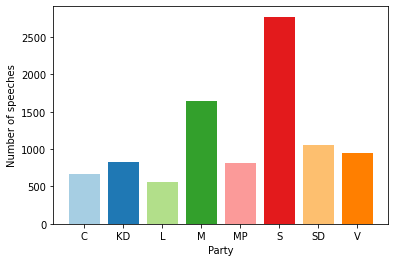

In [39]:
counts_1819 = speeches_201819.groupby(["party"]).size().reset_index(name='counts')

plt.bar(counts_1819["party"], counts_1819["counts"], color=plt.cm.Paired(np.arange(len(counts_1819))))
plt.xlabel("Party")
plt.ylabel("Number of speeches")
plt.show()

## Problem 2: Naive Bayes classifier

You are now ready to train and evaluate a classifier. More specifically, we ask you to train a [Multinomial Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes) classifier. You will have to

1. vectorize the speeches in the training data
2. instantiate and fit the Naive Bayes model
3. evaluate the model on the test data

The scikit-learn library provides a convenience class [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) that allows you to solve the first two tasks with very compact code. For the evaluation you can use the function [`classification_report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html), which will report per-class precision, recall and F1, as well as overall accuracy.

In [40]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

pipe = Pipeline([("countVectorizer", CountVectorizer()), ("multinomialNB", MultinomialNB())])

X_train = training_data["words"]
y_train = training_data["party"]
X_test = test_data["words"]
y_test = test_data["party"]

# Fit model on training_data
pipe.fit(X_train, y_train)

# Predictions on test_data
y_pred = pipe.predict(X_test)

# Evaluate model reporting accuracy, precision, recall and F1
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           C       0.63      0.04      0.07       671
          KD       0.70      0.02      0.03       821
           L       0.92      0.02      0.04       560
           M       0.36      0.68      0.47      1644
          MP       0.36      0.25      0.29       809
           S       0.46      0.84      0.59      2773
          SD       0.57      0.12      0.20      1060
           V       0.59      0.15      0.24       950

    accuracy                           0.43      9288
   macro avg       0.57      0.26      0.24      9288
weighted avg       0.52      0.43      0.34      9288



Would you have expected the results that you got?

**A:** Yes, we expected the results to be like that. From the imbalance of our training distribution it follows that some parties are over-represented and some are under-represented which results in worse predictions seen in the evaluation. 

## Problem 3: Baselines

Evaluation metrics such as accuracy should not be understood as absolute measures of performance, but should be used only to compare different classifiers. When other classifiers are not available, a simple baseline is a classifier that generates predictions by random sampling, respecting the training set&rsquo;s class distribution. This baseline is implemented by the class [DummyClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html). What is the performance of the random baseline on the test data?

In [41]:
from sklearn.dummy import DummyClassifier

# Using stratified strategy to generate predictions by respecting the training set‚Äôs class distribution
dummy_clf = DummyClassifier(strategy="stratified")

dummy_clf.fit(X_train, y_train)
y_pred = dummy_clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           C       0.07      0.07      0.07       671
          KD       0.08      0.06      0.07       821
           L       0.08      0.07      0.07       560
           M       0.17      0.18      0.17      1644
          MP       0.09      0.12      0.10       809
           S       0.29      0.34      0.32      2773
          SD       0.12      0.09      0.10      1060
           V       0.11      0.07      0.09       950

    accuracy                           0.18      9288
   macro avg       0.13      0.13      0.12      9288
weighted avg       0.17      0.18      0.17      9288



An even dumber baseline is to predict, for every document, that class which appears most often in the training data. This baseline is also called the most frequent class baseline. What is the accuracy of that baseline on the test data?

In [42]:
# Using most_frequent strategy to always predict the most frequent label in the training set.
dummy_clf = DummyClassifier(strategy="most_frequent")

dummy_clf.fit(X_train, y_train)
y_pred = dummy_clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           C       0.00      0.00      0.00       671
          KD       0.00      0.00      0.00       821
           L       0.00      0.00      0.00       560
           M       0.00      0.00      0.00      1644
          MP       0.00      0.00      0.00       809
           S       0.30      1.00      0.46      2773
          SD       0.00      0.00      0.00      1060
           V       0.00      0.00      0.00       950

    accuracy                           0.30      9288
   macro avg       0.04      0.12      0.06      9288
weighted avg       0.09      0.30      0.14      9288



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Problem 4: Creating a balanced data set

As you saw in Problem&nbsp;1, the distribution of the speeches over the eight different parties (classes) is imbalanced. One technique used to alleviate this is **undersampling**, in which one randomly removes samples from over-represented classes until all classes are represented with the same number of samples.

Implement undersampling to create a balanced subset of the training data. Rerun the evaluation from Problem&nbsp;2 on the balanced data and compare the results. Summarise your results in a short text.

**Hint:** Your balanced subset should consist of 5,752 speeches.

In [43]:
min_speeches = counts_1718["counts"].min()

training_data_balanced = pd.DataFrame()
for party in parties:
    training_data_party = training_data[training_data["party"] == party]
    sample_to_concat = training_data_party.sample(min_speeches)
    training_data_balanced = pd.concat([training_data_balanced, sample_to_concat], axis=0)
    
training_data_balanced.shape

(5752, 3)

In [44]:
pipe = Pipeline([("countVectorizer", CountVectorizer()), ("multinomialNB", MultinomialNB())])

X_train = training_data_balanced["words"]
y_train = training_data_balanced["party"]
X_test = test_data["words"]
y_test = test_data["party"]

# Fit model on training_data
pipe.fit(X_train, y_train)

# Predictions on test_data
y_pred = pipe.predict(X_test)

# Evaluate model reporting accuracy, precision, recall and F1
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           C       0.28      0.41      0.33       671
          KD       0.30      0.36      0.33       821
           L       0.29      0.46      0.36       560
           M       0.40      0.48      0.44      1644
          MP       0.33      0.38      0.35       809
           S       0.76      0.33      0.46      2773
          SD       0.45      0.44      0.45      1060
           V       0.41      0.56      0.47       950

    accuracy                           0.41      9288
   macro avg       0.40      0.43      0.40      9288
weighted avg       0.48      0.41      0.42      9288



**A:** We used the minimum number of speeches for a party which is 719 to remove samples from over-represented classes (more than 719 speeches). By looping over all possible target values (parties) and concatenating 719 speeches from each party, we generate a new balanced training dataset. The resulting dataset now consists of 5752 speeches in total (719 speeches x 8 parties).

From the evaluation we can see that the overall accuracy went down by 2%. On the other hand, we can observe a more balanced inter-class accuracy. From the f1-score we can see that our predictions are not as much varying as in problem 2. Thus, we can state that undersampling helped us making more robust predictions while at the same time lowering the overall accuracy. 

## Problem 5: Confusion matrix

A **confusion matrix** is a specific table that is useful when analysing the performance of a classifier. In this table, both the rows and the columns correspond to classes, and each cell $(i, j)$ states how many times a sample with gold-standard class $i$ was predicted as belonging to class $j$.

In scitkit-learn, the confusion matrix of a classifier is computed by the function [`confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html). If you would rather see a visual representation, you can also use [`plot_confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html).

Your task is to use the confusion matrix in order to find, for each given party $p$ in the Riksdag, that other party $p'$ which the classifier that you trained in Problem&nbsp;4 most often confuses with $p$ when it predicts the party of a speaker.

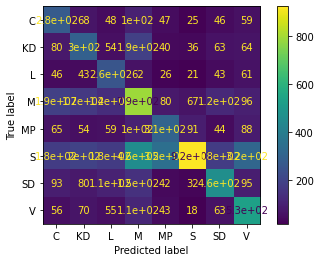

In [45]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(pipe, X_test, y_test) 
plt.show()

**A:** The observations from the confusion matrix make sense. Since we created a more balanced classification model we can see that the misclassifications are more or less proportional. We can also observe that for all parties the most predicted label is actually the true label. An interesting observation is that M is the most misclassified label for any party except L and MP.

## Problem 6: Grid search

Until now, you have been using the vectorizer and the Naive Bayes classifier with their default hyperparameters. When working with real-world applications, you would want to find settings for the hyperparameters that maximize the performance for the task at hand.

Manually tweaking the hyperparameters of the various components of a vectorizer‚Äìclassifier pipeline can be cumbersome. However, scikit-learn makes it possible to run an exhaustive search for the best hyperparameters over a grid of possible values. This method is known as **grid search**.

The hyperparameters of a pipeline should never be tuned on the final test set. Instead, one should either use a separate validation set, or run cross-validation over different folds. Here we will use cross-validation.

Implement a grid search with 5-fold cross-validation to find the optimal parameters in a grid defined by the following choices for the hyperparameters:

* In the vectorizer, try a set-of-words (binary) model in addition to the default bag-of-words model (two possible parameter values).
* Also in the vectorizer, try extracting bigrams in addition to unigrams (two possible parameter values).
* In the Naive Bayes classifier, try using additive smoothing with $\alpha \in \{1, 0{.}1\}$ (two possible parameter values).

Use the class [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) from the scikit-learn library. Print the results of your best model, along with the parameter values that yielded these results.

In [46]:
from sklearn.model_selection import GridSearchCV

In [47]:
# TODO: Write code here to implement the grid search
# pipe.get_params().keys()
params = {"countVectorizer__binary": [True, False],
          "countVectorizer__ngram_range": [(1,1), (1,2)],
          "multinomialNB__alpha": [0.1, 1]}

grid_param = GridSearchCV(pipe, params, cv=5, verbose = 1)

grid_param.fit(training_data["words"], training_data["party"])

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  5.5min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('countVectorizer',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                 

In [48]:
# Best parameter values
best_grid_param = grid_param.best_params_
best_grid_param

{'countVectorizer__binary': False,
 'countVectorizer__ngram_range': (1, 1),
 'multinomialNB__alpha': 0.1}

In [49]:
# grid_param.cv_results_

# On training data
predict_train = grid_param.best_estimator_.predict(training_data["words"])
# On test data
predict_test = grid_param.best_estimator_.predict(test_data["words"])

In [50]:
# classification report for optimal parameters (training set)
print(classification_report(training_data["party"], predict_train))

              precision    recall  f1-score   support

           C       0.95      0.96      0.96       865
          KD       0.97      0.97      0.97       743
           L       0.95      0.98      0.97       719
           M       0.94      0.96      0.95      2370
          MP       0.92      0.92      0.92      1481
           S       0.97      0.93      0.95      4261
          SD       0.93      0.97      0.95      1010
           V       0.92      0.97      0.94       894

    accuracy                           0.95     12343
   macro avg       0.94      0.96      0.95     12343
weighted avg       0.95      0.95      0.95     12343



In [51]:
# classification report for optimal parameters (test set)
print(classification_report(test_data["party"], predict_test))

              precision    recall  f1-score   support

           C       0.39      0.27      0.32       671
          KD       0.45      0.24      0.31       821
           L       0.37      0.26      0.30       560
           M       0.44      0.58      0.50      1644
          MP       0.32      0.46      0.38       809
           S       0.61      0.65      0.63      2773
          SD       0.49      0.43      0.45      1060
           V       0.50      0.42      0.46       950

    accuracy                           0.48      9288
   macro avg       0.45      0.41      0.42      9288
weighted avg       0.48      0.48      0.48      9288



**A**: We get overall better scores using the crossvalidation method. This is due to the fact that we make an exhaustive search through parameters in order to find the appropriate set for our data. One should however be aware of the risks of overfitting when using this method as attested by the sharp drop in accuracy between the training performance and the test set.

## Problem 7: Try to improve your results

Scikit-learn makes it easy to test different vectorizer‚Äìclassifier pipelines ‚Äì among other things, it includes different types of logistic regression classifiers, support vector machines, and decision trees. Browse the library to see which methods are supported.

Build a pipeline that you find interesting, and use grid search to find optimal settings for the hyperparameters. Print the results of your best model.

In [52]:
#Including Swedish stop words
# courtesy of https://github.com/peterdalle/svensktext

# common stop words
common_stop_se = '''
all
alla
allas
allt
allts√•
andra
andras
annan
annat
artonde
artonn
att
av
bakom
bara
bland
blev
bli
blir
blivit
b√•da
b√•das
b√•de
dag
dagar
dagarna
dagen
de
del
delen
dem
den
denna
deras
dess
dessa
det
detta
dig
din
dina
dit
ditt
dock
dom
du
d√§r
d√§rf√∂r
d√•
efter
eftersom
ej
elfte
eller
elva
en
er
era
ert
ett
fall
fanns
fast
fem
femte
femtio
femtionde
femton
femtonde
fick
fin
finnas
finns
fjorton
fjortonde
fj√§rde
fler
flera
flesta
fram
framf√∂r
fr√•n
fyra
fyrtio
fyrtionde
f√•
f√•r
f√•tt
f√∂r
f√∂re
f√∂rra
f√∂rsta
ge
genom
ger
gick
gjorde
gjort
g√§lla
g√§ller
g√§llt
g√§rna
g√•
g√•ng
g√•r
g√•tt
g√∂r
g√∂ra
ha
hade
haft
han
hans
har
hela
heller
hellre
helst
helt
henne
hennes
heter
hit
hj√§lp
hon
honom
hundra
hundraen
hundraett
hur
h√§r
i
ibland
icke
igen
in
inf√∂r
inga
ingen
inget
innan
inne
inom
inte
inuti
ja
jag
ju
j√§mf√∂rt
kan
kom
komma
kommer
kommit
kunde
kunna
kunnat
kvar
k√∂r
legat
ligga
ligger
l√§gga
man
med
mellan
men
menar
mer
mera
mig
min
mina
mitt
mittemot
mot
ned
nederst
nedersta
nedre
nej
ner
ni
nio
nionde
nittio
nittionde
nitton
nittonde
nog
noll
nr
nu
nummer
nya
n√§r
n√§sta
n√•gon
n√•gonting
n√•got
n√•gra
n√•n
n√•t
och
ocks√•
om
oss
p√•
rakt
redan
sade
sagt
samt
sedan
sen
ser
sex
sextio
sextionde
sexton
sextonde
sig
sin
sina
sist
sista
siste
sitt
sitta
sju
sjunde
sjuttio
sjuttionde
sjutton
sjuttonde
sj√§lv
sj√§tte
ska
skall
skriver
skulle
slutligen
snart
som
st√•r
s√§ga
s√§ger
s√§tt
s√•
s√•dan
s√•dana
s√•dant
ta
tack
tar
till
tills
tio
tionde
tjugo
tjugoen
tjugoett
tjugonde
tjugotre
tjugotv√•
tjungo
tog
tolfte
tolv
tre
tredje
trettio
trettionde
tretton
trettonde
tro
tror
tv√•
tv√•hundra
under
upp
ur
ut
utan
utanf√∂r
ute
vad
var
vara
varf√∂r
varifr√•n
varit
varje
varken
vars
vars√•god
vart
vem
vems
verkligen
vet
vi
vid
vidare
vilka
vilkas
vilken
vilket
vill
visst
v√§l
v√§rre
v√•r
v√•ra
v√•rt
√§n
√§nd√•
√§nnu
√§r
√§ven
√•ret
√•t
√•tminstone
√•tta
√•ttio
√•ttionde
√•ttonde
√∂ver
√∂vre'''.split()

# stop words political 

politic_stop_se = '''allts√•
att
av
bakom
bara
bland
blev
bli
blir
blivit
b√•da
b√•das
b√•de
de
del
delen
dem
den
denna
deras
dess
dessa
det
detta
dig
din
dina
dit
ditt
dock
dom
du
d√§r
d√§rf√∂r
d√•
efter
eftersom
elfte
eller
elva
en
enkel
enkelt
enkla
enligt
er
era
ert
ett
fall
fanns
fast
fick
fin
finnas
finns
fler
flera
flesta
fram
framf√∂r
fr√•n
f√•
f√•r
f√•tt
f√∂ljande
f√∂r
f√∂re
f√∂rra
f√∂rsta
ge
genast
genom
ger
gick
gjorde
gjort
g√§lla
g√§ller
g√§llt
g√•
g√•ng
g√•r
g√•tt
g√∂r
g√∂ra
ha
hade
haft
han
hans
har
hela
heller
hellre
helst
helt
henne
hennes
heter
hit
hon
honom
hur
h√§r
i
ibland
idag
igen
ig√•r
imorgon
in
inf√∂r
inga
innan
inne
inom
inte
inuti
ja
jag
j√§mf√∂rt
kan
kanske
knappast
kolla
kom
komma
kommer
kommit
kunde
kunna
kunnat
kvar
k√∂r
legat
ligga
ligger
lilla
lite
liten
litet
l√§gga
l√§nge
l√§ngre
l√§ngst
l√§tt
l√§ttare
l√§ttast
l√•ngsam
l√•ngsammare
l√•ngsammast
l√•ngsamt
l√•ngt
man
med
mellan
men
menar
mer
mera
mest
mig
min
mina
mindre
minst
mitt
mittemot
mot
mycket
m√•nga
m√•ste
m√∂jlig
m√∂jligen
m√∂jligt
m√∂jligtvis
ned
nederst
nedersta
nedre
nej
ner
ni
nog
nr
nu
n√§r
n√§sta
n√•gon
n√•gonting
n√•got
n√•gra
n√•n
n√•t
och
ocks√•
ofta
oftast
olika
olikt
om
oss
p√•
rakt
redan
r√§tt
sade
sagt
samma
samt
sedan
sen
senare
senast
sent
sig
sin
sina
sist
sista
siste
sitt
ska
skall
skulle
slutligen
sm√•
sm√•tt
snart
som
stor
stora
stort
st√•r
s√§ga
s√§ger
s√§tt
s√•
ta
tar
till
tills
under
upp
ur
ut
utan
ute
vad
var
vara
varf√∂r
varifr√•n
varit
varje
varken
vart
vem
vems
vet
vi
vid
vidare
vilka
vilken
vilket
vill
visst
v√§l
v√§rre
v√•r
v√•ra
v√•rt
√§n
√§nd√•
√§nnu
√§r
√§ven
√•tminstone
√∂ver
√∂vermorgon
ser
skriver
tog'''.split()


In [54]:
# TODO: Write code here to search for a better model and print the results
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Improved pipeline
pipe_improve = Pipeline([("countVectorizer", CountVectorizer()), ("LogisticRegression", LogisticRegression(warm_start = True, multi_class="multinomial", solver="lbfgs"))])
# pipe_improve.get_params().keys()
# Parameters to grid search over
param_improve = {"countVectorizer__ngram_range": [(1,1), (1,2)],
                 "countVectorizer__binary": [True, False],
                 "LogisticRegression__C": [0.3, 0.6, 0.9, 1.0], #inverse of regularization strength
                 "countVectorizer__stop_words": [None, politic_stop_se, common_stop_se]} # Improve further by introducing swedish stop words?                                                                      
# 6H COMPUTATION!!!!!
grid_param_improve = GridSearchCV(pipe_improve, param_improve, cv=5, verbose = 2)

grid_param_improve.fit(training_data["words"], training_data["party"])


Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] LogisticRegression__C=0.3, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.3, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None, total=  24.0s
[CV] LogisticRegression__C=0.3, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.1s remaining:    0.0s
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.3, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None, total=  23.7s
[CV] LogisticRegression__C=0.3, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.3, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None, total=  23.5s
[CV] LogisticRegression__C=0.3, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.3, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None, total=  23.6s
[CV] LogisticRegression__C=0.3, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.3, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None, total=  23.1s
[CV] LogisticRegression__C=0.3, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.3, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom', 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.3, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom', 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.3, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom', 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.3, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom', 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.3, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom', 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.3, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.3, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.3, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.3, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.3, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.3, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None, total= 2.6min
[CV] LogisticRegression__C=0.3, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.3, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None, total= 2.6min
[CV] LogisticRegression__C=0.3, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.3, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None, total= 2.7min
[CV] LogisticRegression__C=0.3, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.3, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None, total= 2.6min
[CV] LogisticRegression__C=0.3, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.3, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None, total= 2.6min
[CV] LogisticRegression__C=0.3, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.3, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom', 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.3, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom', 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.3, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom', 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.3, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom', 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.3, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom', 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.3, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.3, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.3, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.3, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.3, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.3, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None, total=  22.7s
[CV] LogisticRegression__C=0.3, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.3, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None, total=  22.5s
[CV] LogisticRegression__C=0.3, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.3, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None, total=  22.7s
[CV] LogisticRegression__C=0.3, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.3, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None, total=  23.3s
[CV] LogisticRegression__C=0.3, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.3, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None, total=  22.3s
[CV] LogisticRegression__C=0.3, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.3, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom',

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.3, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom',

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.3, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom',

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.3, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom',

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.3, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom',

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.3, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', '

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.3, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', '

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.3, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', '

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.3, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', '

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.3, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', '

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.3, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None, total= 2.6min
[CV] LogisticRegression__C=0.3, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.3, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None, total= 2.6min
[CV] LogisticRegression__C=0.3, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.3, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None, total= 2.6min
[CV] LogisticRegression__C=0.3, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.3, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None, total= 2.6min
[CV] LogisticRegression__C=0.3, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.3, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None, total= 2.6min
[CV] LogisticRegression__C=0.3, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.3, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom',

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.3, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom',

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.3, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom',

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.3, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom',

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.3, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom',

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.3, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', '

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.3, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', '

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.3, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', '

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.3, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', '

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.3, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', '

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.6, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None, total=  23.1s
[CV] LogisticRegression__C=0.6, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.6, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None, total=  23.5s
[CV] LogisticRegression__C=0.6, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.6, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None, total=  22.8s
[CV] LogisticRegression__C=0.6, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.6, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None, total=  22.6s
[CV] LogisticRegression__C=0.6, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.6, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None, total=  22.7s
[CV] LogisticRegression__C=0.6, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.6, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom', 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.6, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom', 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.6, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom', 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.6, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom', 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.6, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom', 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.6, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.6, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.6, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.6, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.6, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.6, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None, total= 2.7min
[CV] LogisticRegression__C=0.6, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.6, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None, total= 2.6min
[CV] LogisticRegression__C=0.6, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.6, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None, total= 2.6min
[CV] LogisticRegression__C=0.6, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.6, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None, total= 2.6min
[CV] LogisticRegression__C=0.6, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.6, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None, total= 2.5min
[CV] LogisticRegression__C=0.6, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.6, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom', 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.6, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom', 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.6, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom', 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.6, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom', 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.6, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom', 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.6, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.6, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.6, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.6, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.6, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.6, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None, total=  23.5s
[CV] LogisticRegression__C=0.6, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.6, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None, total=  24.1s
[CV] LogisticRegression__C=0.6, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.6, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None, total=  23.5s
[CV] LogisticRegression__C=0.6, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.6, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None, total=  23.3s
[CV] LogisticRegression__C=0.6, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.6, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None, total=  23.3s
[CV] LogisticRegression__C=0.6, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.6, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom',

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.6, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom',

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.6, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom',

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.6, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom',

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.6, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom',

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.6, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', '

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.6, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', '

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.6, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', '

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.6, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', '

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.6, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', '

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.6, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None, total= 2.7min
[CV] LogisticRegression__C=0.6, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.6, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None, total= 2.6min
[CV] LogisticRegression__C=0.6, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.6, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None, total= 2.6min
[CV] LogisticRegression__C=0.6, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.6, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None, total= 2.6min
[CV] LogisticRegression__C=0.6, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.6, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None, total= 2.5min
[CV] LogisticRegression__C=0.6, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.6, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom',

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.6, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom',

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.6, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom',

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.6, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom',

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.6, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom',

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.6, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', '

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.6, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', '

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.6, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', '

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.6, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', '

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.6, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', '

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.9, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None, total=  22.7s
[CV] LogisticRegression__C=0.9, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.9, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None, total=  23.7s
[CV] LogisticRegression__C=0.9, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.9, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None, total=  23.1s
[CV] LogisticRegression__C=0.9, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.9, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None, total=  23.3s
[CV] LogisticRegression__C=0.9, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.9, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None, total=  22.6s
[CV] LogisticRegression__C=0.9, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.9, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom', 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.9, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom', 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.9, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom', 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.9, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom', 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.9, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom', 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.9, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.9, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.9, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.9, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.9, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.9, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None, total= 2.7min
[CV] LogisticRegression__C=0.9, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.9, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None, total= 2.6min
[CV] LogisticRegression__C=0.9, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.9, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None, total= 2.6min
[CV] LogisticRegression__C=0.9, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.9, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None, total= 2.6min
[CV] LogisticRegression__C=0.9, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.9, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None, total= 2.5min
[CV] LogisticRegression__C=0.9, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.9, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom', 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.9, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom', 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.9, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom', 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.9, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom', 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.9, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom', 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.9, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.9, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.9, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.9, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.9, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.9, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None, total=  24.6s
[CV] LogisticRegression__C=0.9, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.9, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None, total=  23.9s
[CV] LogisticRegression__C=0.9, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.9, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None, total=  23.3s
[CV] LogisticRegression__C=0.9, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.9, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None, total=  23.3s
[CV] LogisticRegression__C=0.9, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.9, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None, total=  22.9s
[CV] LogisticRegression__C=0.9, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.9, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom',

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.9, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom',

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.9, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom',

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.9, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom',

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.9, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom',

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.9, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', '

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.9, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', '

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.9, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', '

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.9, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', '

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.9, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', '

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.9, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None, total= 2.6min
[CV] LogisticRegression__C=0.9, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.9, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None, total= 2.6min
[CV] LogisticRegression__C=0.9, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.9, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None, total= 2.6min
[CV] LogisticRegression__C=0.9, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.9, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None, total= 2.6min
[CV] LogisticRegression__C=0.9, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.9, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None, total= 2.5min
[CV] LogisticRegression__C=0.9, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.9, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom',

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.9, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom',

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.9, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom',

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.9, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom',

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.9, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom',

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.9, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', '

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.9, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', '

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.9, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', '

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.9, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', '

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=0.9, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', '

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=1.0, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None, total=  23.1s
[CV] LogisticRegression__C=1.0, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=1.0, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None, total=  23.2s
[CV] LogisticRegression__C=1.0, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=1.0, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None, total=  23.4s
[CV] LogisticRegression__C=1.0, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=1.0, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None, total=  23.2s
[CV] LogisticRegression__C=1.0, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=1.0, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None, total=  23.1s
[CV] LogisticRegression__C=1.0, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=1.0, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom', 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=1.0, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom', 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=1.0, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom', 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=1.0, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom', 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=1.0, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom', 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=1.0, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=1.0, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=1.0, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=1.0, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=1.0, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=1.0, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None, total= 2.7min
[CV] LogisticRegression__C=1.0, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=1.0, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None, total= 2.6min
[CV] LogisticRegression__C=1.0, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=1.0, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None, total= 2.6min
[CV] LogisticRegression__C=1.0, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=1.0, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None, total= 2.6min
[CV] LogisticRegression__C=1.0, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=1.0, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None, total= 2.5min
[CV] LogisticRegression__C=1.0, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=1.0, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom', 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=1.0, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom', 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=1.0, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom', 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=1.0, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom', 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=1.0, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom', 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=1.0, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=1.0, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=1.0, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=1.0, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=1.0, countVectorizer__binary=True, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=1.0, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None, total=  22.5s
[CV] LogisticRegression__C=1.0, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=1.0, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None, total=  23.8s
[CV] LogisticRegression__C=1.0, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=1.0, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None, total=  23.3s
[CV] LogisticRegression__C=1.0, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=1.0, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None, total=  22.1s
[CV] LogisticRegression__C=1.0, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=1.0, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=None, total=  22.0s
[CV] LogisticRegression__C=1.0, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=1.0, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom',

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=1.0, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom',

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=1.0, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom',

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=1.0, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom',

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=1.0, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom',

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=1.0, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', '

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=1.0, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', '

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=1.0, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', '

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=1.0, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', '

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=1.0, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', '

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=1.0, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None, total= 2.7min
[CV] LogisticRegression__C=1.0, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=1.0, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None, total= 2.6min
[CV] LogisticRegression__C=1.0, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=1.0, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None, total= 2.6min
[CV] LogisticRegression__C=1.0, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=1.0, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None, total= 2.6min
[CV] LogisticRegression__C=1.0, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=1.0, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=None, total= 2.5min
[CV] LogisticRegression__C=1.0, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=1.0, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom',

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=1.0, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom',

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=1.0, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom',

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=1.0, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom',

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=1.0, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['allts√•', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'elfte', 'eller', 'elva', 'en', 'enkel', 'enkelt', 'enkla', 'enligt', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fick', 'fin', 'finnas', 'finns', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'f√•', 'f√•r', 'f√•tt', 'f√∂ljande', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genast', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', 'g√§llt', 'g√•', 'g√•ng', 'g√•r', 'g√•tt', 'g√∂r', 'g√∂ra', 'ha', 'hade', 'haft', 'han', 'hans', 'har', 'hela', 'heller', 'hellre', 'helst', 'helt', 'henne', 'hennes', 'heter', 'hit', 'hon', 'honom',

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=1.0, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', '

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=1.0, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', '

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=1.0, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', '

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=1.0, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', '

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  LogisticRegression__C=1.0, countVectorizer__binary=False, countVectorizer__ngram_range=(1, 2), countVectorizer__stop_words=['all', 'alla', 'allas', 'allt', 'allts√•', 'andra', 'andras', 'annan', 'annat', 'artonde', 'artonn', 'att', 'av', 'bakom', 'bara', 'bland', 'blev', 'bli', 'blir', 'blivit', 'b√•da', 'b√•das', 'b√•de', 'dag', 'dagar', 'dagarna', 'dagen', 'de', 'del', 'delen', 'dem', 'den', 'denna', 'deras', 'dess', 'dessa', 'det', 'detta', 'dig', 'din', 'dina', 'dit', 'ditt', 'dock', 'dom', 'du', 'd√§r', 'd√§rf√∂r', 'd√•', 'efter', 'eftersom', 'ej', 'elfte', 'eller', 'elva', 'en', 'er', 'era', 'ert', 'ett', 'fall', 'fanns', 'fast', 'fem', 'femte', 'femtio', 'femtionde', 'femton', 'femtonde', 'fick', 'fin', 'finnas', 'finns', 'fjorton', 'fjortonde', 'fj√§rde', 'fler', 'flera', 'flesta', 'fram', 'framf√∂r', 'fr√•n', 'fyra', 'fyrtio', 'fyrtionde', 'f√•', 'f√•r', 'f√•tt', 'f√∂r', 'f√∂re', 'f√∂rra', 'f√∂rsta', 'ge', 'genom', 'ger', 'gick', 'gjorde', 'gjort', 'g√§lla', 'g√§ller', '

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed: 363.5min finished
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('countVectorizer',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                 

In [59]:
from sklearn.externals import joblib
# Save best grid search pipeline to file
dump_file = 'best_grid_search_pipeline.pkl'
joblib.dump(grid_param_improve, dump_file, compress=1)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


['best_grid_search_pipeline.pkl']

In [ ]:
# # Trying out stuff
# from sklearn.linear_model import LogisticRegression
# from sklearn.preprocessing import StandardScaler

# # Improved pipeline
# pipe_improve = Pipeline([("countVectorizer", CountVectorizer()), ("LogisticRegression", LogisticRegression(warm_start = True, solver="saga"))])
# # pipe_improve.get_params().keys()
# # Parameters to grid search over
# param_improve = {"countVectorizer__ngram_range": [(1,1), (1,2)],
#                 #  "countVectorizer__min_df": [4, 6, 8, 10],
#                 #  "countVectorizer__max_df": [0.95, 0.9, 0.85, 0.8],
#                 #  "LogisticRegression__multi_class": ["multinomial", "ovr"],
#                  "LogisticRegression__C": [0.6, 0.8, 1.0],#inverse of regularization strength
#                  "countVectorizer__stop_words": [None, politic_stop_se, common_stop_se]} # Improve further by introducing swedish stop words?                                                                      

# grid_param_improve = GridSearchCV(pipe_improve, param_improve, cv=5, verbose = 2)

# grid_param_improve.fit(training_data["words"], training_data["party"])

In [ ]:
# pipe_improve.get_params().keys()
# # politic_stop_se


In [55]:
# Best parameter values
best_grid_param_improve = grid_param_improve.best_params_
best_grid_param_improve

{'LogisticRegression__C': 0.6,
 'countVectorizer__binary': False,
 'countVectorizer__ngram_range': (1, 2),
 'countVectorizer__stop_words': None}

In [56]:
# grid_param.cv_results_

# On training data
predict_train_improve = grid_param_improve.best_estimator_.predict(training_data["words"])
# On test data
predict_test_improve = grid_param_improve.best_estimator_.predict(test_data["words"])

In [57]:
# classification report for optimal parameters (training set)
print(classification_report(training_data["party"], predict_train_improve))

              precision    recall  f1-score   support

           C       1.00      0.99      1.00       865
          KD       1.00      1.00      1.00       743
           L       1.00      1.00      1.00       719
           M       1.00      0.99      1.00      2370
          MP       1.00      1.00      1.00      1481
           S       0.99      1.00      1.00      4261
          SD       1.00      1.00      1.00      1010
           V       1.00      1.00      1.00       894

    accuracy                           1.00     12343
   macro avg       1.00      1.00      1.00     12343
weighted avg       1.00      1.00      1.00     12343



In [58]:
# classification report for optimal parameters (test set)
print(classification_report(test_data["party"], predict_test))

              precision    recall  f1-score   support

           C       0.39      0.27      0.32       671
          KD       0.45      0.24      0.31       821
           L       0.37      0.26      0.30       560
           M       0.44      0.58      0.50      1644
          MP       0.32      0.46      0.38       809
           S       0.61      0.65      0.63      2773
          SD       0.49      0.43      0.45      1060
           V       0.50      0.42      0.46       950

    accuracy                           0.48      9288
   macro avg       0.45      0.41      0.42      9288
weighted avg       0.48      0.48      0.48      9288



## Reflection questions

The following reflection questions are questions that you could be asked in the oral exam. Try to answer each of them in the form of a short text and enter it in the cell below. You will get feedback on your answers from your lab assistant.

**RQ 2.1:** Summarise the results of your experiments for Problem&nbsp;2. Are your results ‚Äògood‚Äô or ‚Äòbad‚Äô? How do you determine that?

**RQ 2.2:** Summarise the results of your experiments for Problem&nbsp;4. Would you think that your results are typical even for other classification tasks? How would *oversampling* have looked like for this task? When would you use undersampling, when oversampling?

**RQ 2.3:** Which model performed best in your experiments for Problem&nbsp;6? Why is it important to do a hyperparameter search before drawing conclusions about the performance of a model? Why is it often not done, anyway? Why should you never tune hyperparameters on the test set?

**A 2.1** In this problem, we apply the Naive Bayes classifier directly on the dataset without any consideration about class over-representation. We obtain results that show a better accuracy for those classes that are more represented and for which more data is available. On the other hand, under-represented classes show poor accuracy and f1-scores. These results are not bad per se, but are in line with what we expect from biased dataset for which class imbalance is not taken into account.


**A 2.2:** From the evaluation we can see that the overall accuracy went down by 2%. On the other hand, we can observe a more balanced inter-class accuracy. From the f1-score we can see that our predictions are not as much varying as in problem 2. Thus, we can state that undersampling helped us making more robust predictions while at the same time lowering the overall accuracy. Oversampling would imply that we would duplicate (randomly) data from under-represented class a certain number of times in order to have the same class representation for all classes in the dataset. This method does not add any more information to the dataset. However, generating synthetic text using the Synthetic Minority Over-Sampling Technique ([SMOTE](https://arxiv.org/pdf/1106.1813.pdf)) would provide an alternative by generating synthetic data that could add information during the training process and oversample more efficiently. We would use undersampling in the case where the minority classes have enough information to find the decision boundary for our classifier and performs "well enough" compared to the baseline (i.e. we would not see any strong imbalance in our classification that is biased in the same way than our classes in the dataset). We would use oversampling (random or another technique) in the case our underrepresented classes do not have enough information to make up a good decision boundary.

**A 2.3:** As marked in the cell above, our best result is with the following parameters: {'countVectorizer__binary': False, 'countVectorizer__ngram_range': (1, 1),'multinomialNB__alpha': 0.1}. Choosing the best set of parameters is important to do before drawing any conlcusions because they depend strongly on the problem and the training set that is fed to the model. We do no wish to introduce any bias when measuring the performance of the model. This is also the reason why we do not tune the hyperparameters on the test set as the hyperparameter tuning process is also part of the training of the model. Grid search is often not done because it is a lengthy and computationally demanding process if we are to increase the number of folds, fine grain the grid, increase the dimensions (more hyperparameters) in order to find the absolute best combination. We also run the risk of overfitting by adding more complexity to the model which would mean a poor generalization of the model.

**Congratulations on finishing L2! üëç**